In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import glob # To find files
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18, 'figure.figsize': (10, 7)})

# --- Create Synthetic Data (Replace this with loading your own data) ---
def create_synthetic_data():
    """Generates a few types of trajectories for demonstration."""
    if not os.path.exists('sample_trajectories'):
        os.makedirs('sample_trajectories')
    
    # Type 1: Stays low
    for i in range(20):
        time = np.linspace(0, 20, np.random.randint(50, 100))
        distance = 0.1 + np.random.rand(len(time)) * 0.1
        pd.DataFrame({'time': time, 'distance': distance}).to_csv(f'sample_trajectories/low_dwell_{i}.csv', index=False)

    # Type 2: Spikes and decays
    for i in range(20):
        time = np.linspace(0, 20, np.random.randint(50, 100))
        distance = 1.2 * np.exp(-time / 5) + np.random.rand(len(time)) * 0.15
        pd.DataFrame({'time': time, 'distance': distance}).to_csv(f'sample_trajectories/spike_decay_{i}.csv', index=False)
        
    # Type 3: Noisy and high
    for i in range(20):
        time = np.linspace(0, 20, np.random.randint(50, 100))
        distance = 0.6 + np.random.rand(len(time)) * 0.4
        pd.DataFrame({'time': time, 'distance': distance}).to_csv(f'sample_trajectories/noisy_high_{i}.csv', index=False)

# create_synthetic_data() # Run this once to create the data folder

In [2]:
def deconvolute_trajectory_data(file_path):
    """Deconvolutes a trajectory CSV file into individual tracks.

    Args:
        file_path (str): Path to the input CSV file.

    Returns:
        list: A list of DataFrames, each containing a single trajectory.
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    df_list = []
    
    # The csv contains multiple trajectories identified by 'trackID'
    experiments = df['experiment'].unique()
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        for track in np.sort(exp_data['trackID'].unique()):
            track_data = exp_data[exp_data['trackID'] == track]

            # Drop the trackID column
            track_data = track_data.drop(columns=['trackID'])

            # Sort the time points
            track_data = track_data.sort_values(by='t')
            track_data.loc[:, 't'] = track_data['t'] - track_data['t'].min()  # Normalize time to start at 0
            
            # Save to new CSV file
            df_list.append(track_data)

    return df_list

# --- Function to Load and Preprocess Data ---
def load_and_prepare_trajectories(folder_path, file_pattern='FL', n_points=100):
    """
    Loads all trajectory CSVs from a folder and interpolates them to a fixed length.
    
    Args:
        folder_path (str): Path to the folder with trajectory files.
        n_points (int): The number of points to standardize each trajectory to.
        file_pattern (str): A string to filter the csv files by their pattern.

    Returns:
        tuple: A tuple containing the processed data matrix (numpy array) and a list of original trajectories.
    """
    file_paths = glob.glob(os.path.join(folder_path, f'*{file_pattern}*.csv'))
    processed_traces = []
    original_traces = []
    
    # Define the common time axis for interpolation
    common_time = np.linspace(0, 20, n_points) # Assuming max time is 20s
    
    for path in file_paths:
        df = deconvolute_trajectory_data(path)
        # Interpolate the distance values onto the common time axis
        original_traces.append(df)
        print(f"Loaded {os.path.basename(path)} with {len(df)} tracks.")
        
        for temp_df in df:
            interp_distance = np.interp(common_time, temp_df['t'], temp_df['distance_um'])
            processed_traces.append(interp_distance)
    
    if len(file_paths) == 1:
        original_traces = original_traces[0]  # Unwrap if only one file
    
    return np.array(processed_traces), original_traces

# Load your data
# Make sure your files are in a folder named 'sample_trajectories' or change the path
try:
    data_matrix, original_traces = load_and_prepare_trajectories('result', n_points=100)
    print(f"Data prepared successfully. Matrix shape: {data_matrix.shape}")
    # Expected shape: (60, 100) for our 60 synthetic traces of 100 points each
except FileNotFoundError:
    print("Error: 'sample_trajectories' folder not found. Please create it and add your data files, or run the `create_synthetic_data()` function first.")

Loaded 20220508-FLmRNA_2x.csv with 8358 tracks.
Loaded 20220508-FLmRNA-1x.csv with 370 tracks.
Data prepared successfully. Matrix shape: (8728, 100)


In [4]:
# Print the shape of the original traces
print(f"Number of original traces: {len(original_traces)}")

Number of original traces: 2


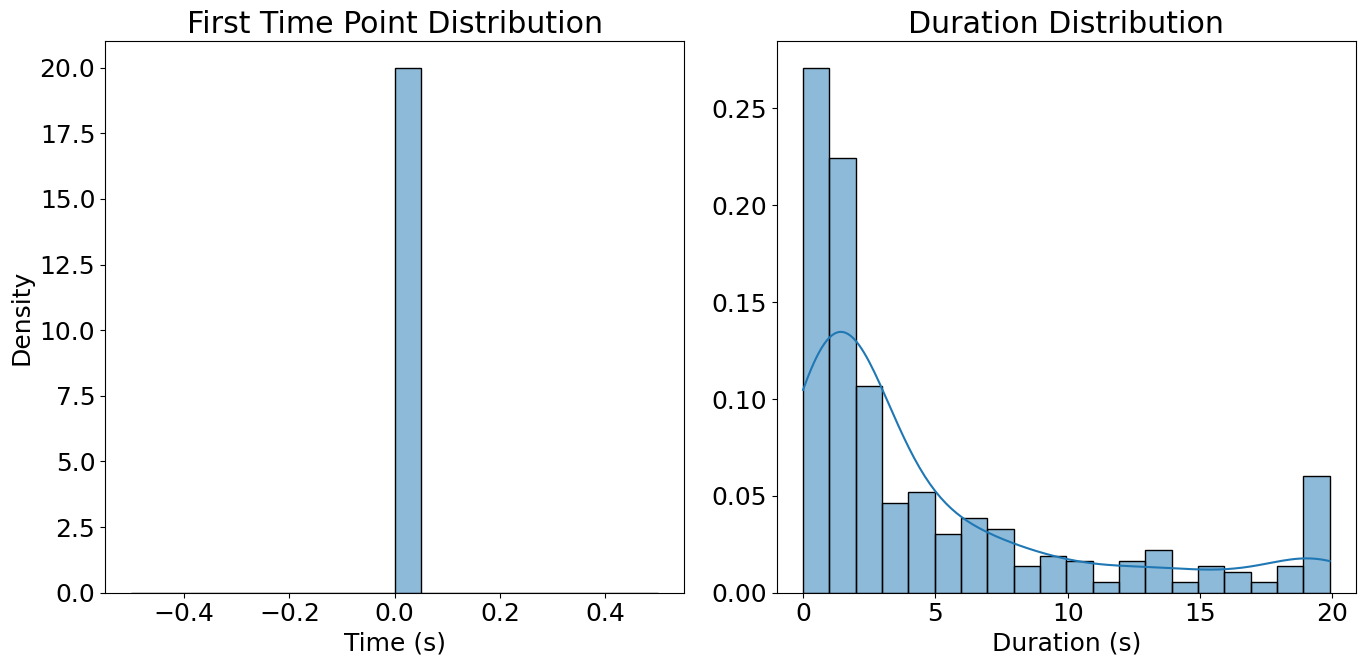

In [99]:
# Generate a histogram of the length of traces (the time points)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

first_time_list = []
last_time_list = []
duration_list = []

for trace_df in original_traces:
    first_time = trace_df['t'].iloc[0]
    last_time = trace_df['t'].iloc[-1]

    first_time_list.append(first_time)
    last_time_list.append(last_time)
    duration_list.append(last_time - first_time)
    
sns.histplot(first_time_list, bins=20, kde=True, ax=ax[0], stat='density')
ax[0].set_title('First Time Point Distribution')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Density')

sns.histplot(duration_list, bins=20, kde=True, ax=ax[1], stat='density')
ax[1].set_title('Duration Distribution')
ax[1].set_xlabel('Duration (s)')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Elbow point at index 223 with last time 3.00s


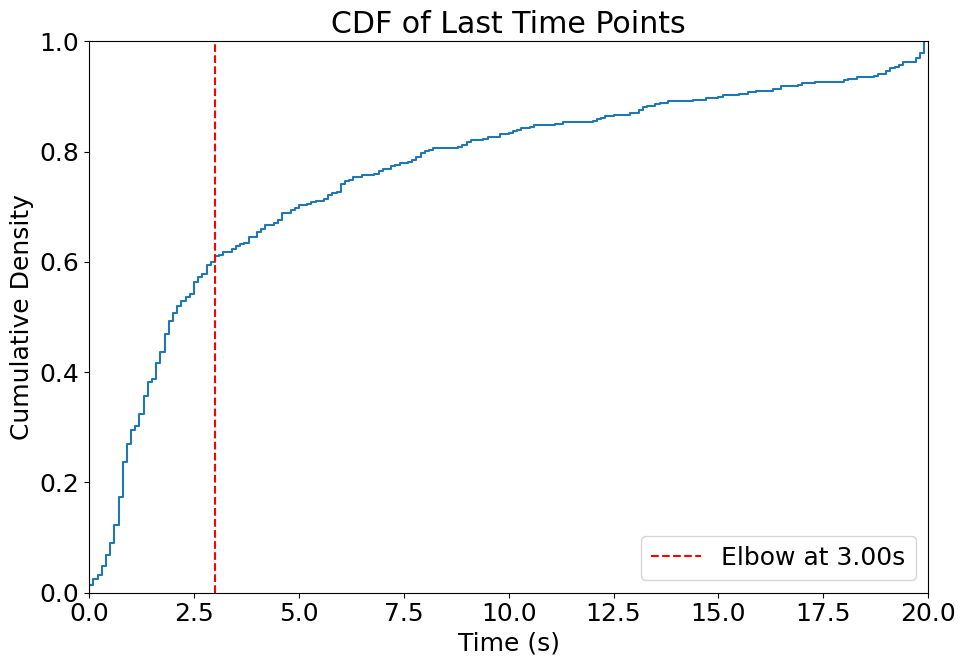

In [100]:
# Generate the CDF of the length of traces (the time points)
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the CDF for the last time points and duration
sns.ecdfplot(last_time_list, ax=ax)

# Find the elbow point in the CDF
sorted_last_times = np.sort(last_time_list)
n = len(sorted_last_times)
x = np.arange(n)
y = sorted_last_times
# Calculate the line from first to last point
line_start = np.array([0, y[0]])
line_end = np.array([n-1, y[-1]])
line_vec = line_end - line_start
line_vec = line_vec / np.linalg.norm(line_vec)

# Calculate distances from each point to the line
distances = []
for i in range(n):
    point = np.array([i, y[i]])
    point_vec = point - line_start
    proj_length = np.dot(point_vec, line_vec)
    proj_point = line_start + proj_length * line_vec
    distance = np.linalg.norm(point - proj_point)
    distances.append(distance)

elbow_index = np.argmax(distances)
elbow_value = sorted_last_times[elbow_index]

print(f"Elbow point at index {elbow_index} with last time {elbow_value:.2f}s")
ax.axvline(elbow_value, color='red', linestyle='--', label=f'Elbow at {elbow_value:.2f}s')
ax.legend()

ax.set_title('CDF of Last Time Points')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cumulative Density')
ax.set_xlim(0, 20)

plt.tight_layout()
plt.show()

Looking at the CDF plot, I'll try to cut by 5.0 s first.
- If $t_{max}$ < 5 s, remove
- If $t_{max} \geq$ 5 s, truncate the data points higher than 5.0 s

In [101]:
original_traces[0]

,experiment,t,distance_um,t_dwell
0,20220508-FLmRNA_2x_FOV-1,0.0,-0.002499,0.8
1,20220508-FLmRNA_2x_FOV-1,0.1,0.098427,0.8
2,20220508-FLmRNA_2x_FOV-1,0.2,0.099517,0.8
3,20220508-FLmRNA_2x_FOV-1,0.3,0.102241,0.8
4,20220508-FLmRNA_2x_FOV-1,0.4,0.089175,0.8
...,...,...,...,...
73,20220508-FLmRNA_2x_FOV-1,7.3,0.056672,0.8
74,20220508-FLmRNA_2x_FOV-1,7.4,0.152455,0.8
75,20220508-FLmRNA_2x_FOV-1,7.5,0.180256,0.8
76,20220508-FLmRNA_2x_FOV-1,7.6,0.091213,0.8


In [102]:
t_max = elbow_value # Use the elbow value from the CDF analysis, it was 2.5 before (arbitrarily chosen)
common_time = np.linspace(0, t_max, int(t_max*10)) # 0.1 s intervals to match the camera's frame rate

length_matrix = []
interp_length_matrix = []
filtered_data_matrix = []
filtered_traces = []

for trace_df in original_traces:
    if trace_df['t'].max() < t_max:
        continue  # Skip this trace entirely
    else:
        trace_df = trace_df[trace_df['t'] <= t_max]  # Truncate to t_max
        filtered_traces.append(trace_df)
        
        # trace_df = trace_df.drop(columns=['experiment'], errors='ignore')  # Drop "experiment" column if exists
        distance = np.array(trace_df['distance_um'].values)
        interp_distance = np.interp(common_time, trace_df['t'], distance)
        
        filtered_data_matrix.append(interp_distance)
        length_matrix.append(len(distance))
        interp_length_matrix.append(len(interp_distance))

data_matrix = np.array(filtered_data_matrix)
length_matrix = np.array(length_matrix)
interp_length_matrix = np.array(interp_length_matrix)
print(f"Filtered data matrix shape: {np.array(data_matrix).shape}")
print(f"Filtered traces shape: {len(filtered_traces)}")

Filtered data matrix shape: (147, 30)
Filtered traces shape: 147


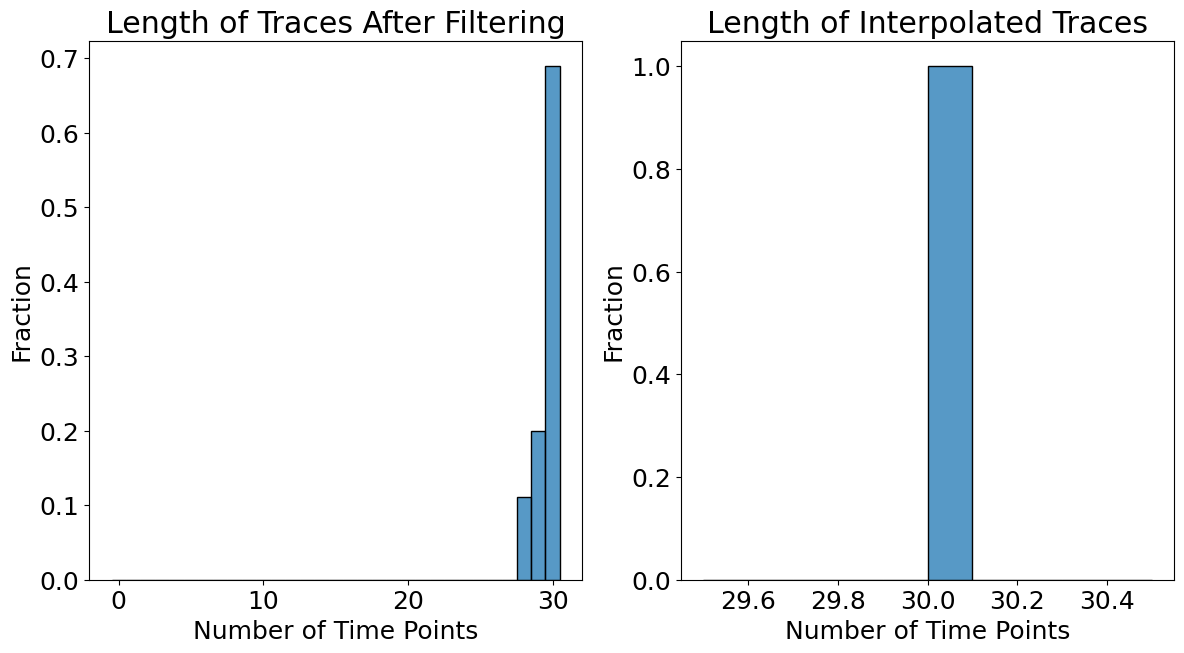

In [103]:
# Check the length of the trace after filtering and interpolation
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

bin_width = 1
filter_bins = (np.arange(0, length_matrix.max() + bin_width, bin_width) - 0.5)

sns.histplot(length_matrix, bins=filter_bins, kde=False, ax=ax[0], stat='probability')

ax[0].set_title('Length of Traces After Filtering')
ax[0].set_xlabel('Number of Time Points')
ax[0].set_ylabel('Fraction')

interp_bins = 10

sns.histplot(interp_length_matrix, bins=interp_bins, kde=False, ax=ax[1], stat='probability')
ax[1].set_title('Length of Interpolated Traces')
ax[1].set_xlabel('Number of Time Points')
ax[1].set_ylabel('Fraction')

plt.show()

In [104]:
try: 
    import umap
    import hdbscan
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
except ImportError:
    !pip install umap-learn hdbscan
    import umap
    import hdbscan

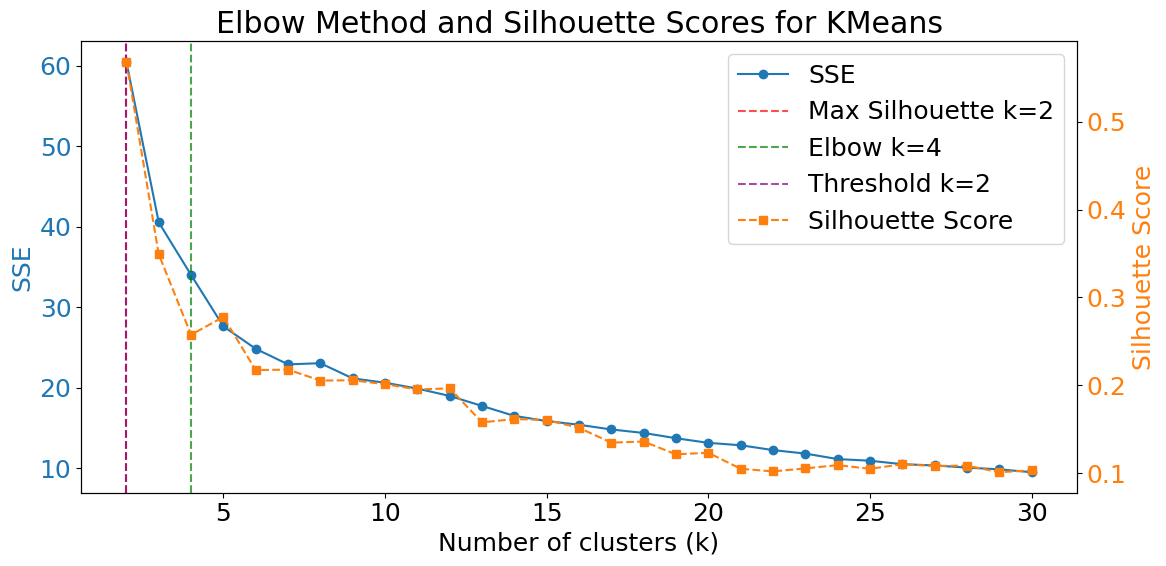

Optimal k recommendations:
  Max Silhouette Score: 2
  Elbow Method: 4
  Silhouette Threshold: 2

Recommended k: 4


In [105]:
def optimal_kmeans(data, max_k=10):
    """
    Determines the optimal number of clusters for KMeans using multiple methods.
    
    Args:
        data (numpy array): The input data for clustering.
        max_k (int): The maximum number of clusters to test.
    Returns:
        dict: Dictionary containing optimal k from different methods.
    """
    sse = []
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Plot the elbow method
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('SSE', color=color)
    ax1.plot(K, sse, 'o-', color=color, label='SSE')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(K, silhouette_scores, 's--', color=color, label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Different methods to find optimal k
    # Method 1: Highest silhouette score
    optimal_k_silhouette = K[np.argmax(silhouette_scores)]
    
    # Method 2: Elbow method (using knee detection)
    # Simple elbow detection: find point with maximum curvature
    sse_diff = np.diff(sse)
    sse_diff2 = np.diff(sse_diff)
    if len(sse_diff2) > 0:
        optimal_k_elbow = K[np.argmax(sse_diff2) + 2]  # +2 because of double diff
    else:
        optimal_k_elbow = K[0]
    
    # Method 3: Silhouette score threshold (>0.5 is good, >0.7 is excellent)
    good_silhouette_indices = np.where(np.array(silhouette_scores) > 0.5)[0]
    if len(good_silhouette_indices) > 0:
        optimal_k_threshold = K[good_silhouette_indices[0]]  # First k with good silhouette
    else:
        optimal_k_threshold = optimal_k_silhouette
    
    # Add vertical lines for different optimal k values
    ax1.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, 
                label=f'Max Silhouette k={optimal_k_silhouette}')
    ax1.axvline(x=optimal_k_elbow, color='green', linestyle='--', alpha=0.7, 
                label=f'Elbow k={optimal_k_elbow}')
    ax1.axvline(x=optimal_k_threshold, color='purple', linestyle='--', alpha=0.7, 
                label=f'Threshold k={optimal_k_threshold}')
    
    plt.title('Elbow Method and Silhouette Scores for KMeans')
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Return multiple recommendations
    results = {
        'max_silhouette': optimal_k_silhouette,
        'elbow': optimal_k_elbow, 
        'threshold': optimal_k_threshold,
        'silhouette_scores': silhouette_scores,
        'sse': sse
    }
    
    return results

# Find the optimal number of clusters
optimal_results = optimal_kmeans(data_matrix, max_k=30)
print(f"Optimal k recommendations:")
print(f"  Max Silhouette Score: {optimal_results['max_silhouette']}")
print(f"  Elbow Method: {optimal_results['elbow']}")
print(f"  Silhouette Threshold: {optimal_results['threshold']}")

# Use the max silhouette score as default
optimal_k = optimal_results['elbow']
print(f"\nRecommended k: {optimal_k}")

In [106]:
# --- 1. UMAP: The Mapmaker ---
# Create the low-dimensional map of your data.
n_neighbors = 5
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data_matrix)

# --- 2. KMeans: The Census Taker ---
# Analyze the map to find a specific number of clusters.
N_CLUSTERS_TO_FIND = optimal_k  # Use the optimal number of clusters found
kmeans = KMeans(n_clusters=N_CLUSTERS_TO_FIND, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(embedding)

# --- 3. Report Results ---
print(f"Assigned data to {N_CLUSTERS_TO_FIND} clusters using KMeans.")
for label in np.unique(cluster_labels):
    count = np.sum(cluster_labels == label)
    print(f"Cluster {label}: {count} traces ({count/len(cluster_labels)*100:.1f}%)")

print(f"Total traces: {len(cluster_labels)}")

Assigned data to 4 clusters using KMeans.
Cluster 0: 52 traces (35.4%)
Cluster 1: 55 traces (37.4%)
Cluster 2: 13 traces (8.8%)
Cluster 3: 27 traces (18.4%)
Total traces: 147


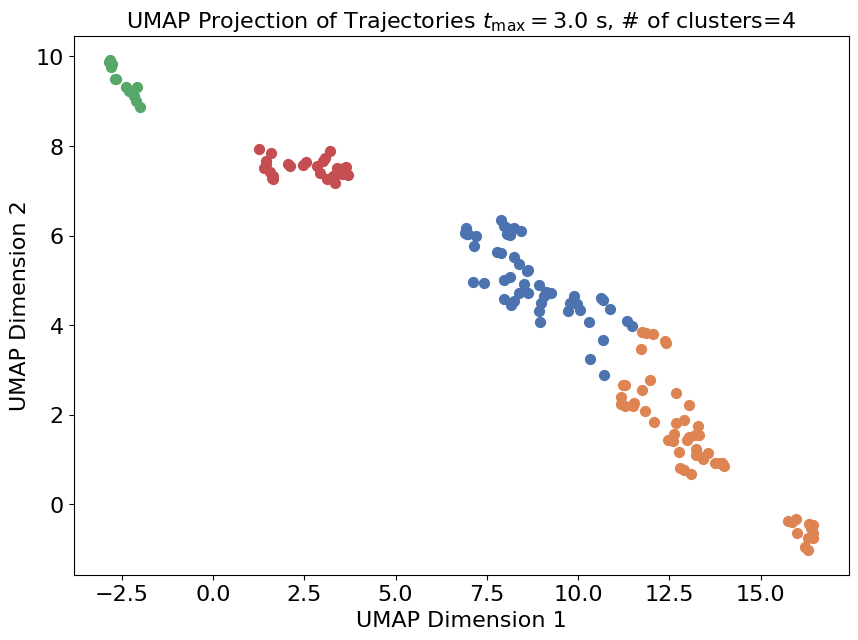

In [107]:
# --- Plot 1: The UMAP Projection Colored by Cluster ---
fig, ax = plt.subplots(figsize=(10, 7))

# Create a color palette
unique_labels = np.unique(cluster_labels)
colors = sns.color_palette("deep", len(unique_labels))
color_map = {label: color for label, color in zip(unique_labels, colors)}

# Plot each cluster
for label in unique_labels:
    indices = np.where(cluster_labels == label)[0]
    if label == -1:
        ax.scatter(embedding[indices, 0], embedding[indices, 1], c='lightgray', s=20, label='Noise')
    else:
        ax.scatter(embedding[indices, 0], embedding[indices, 1], c=[color_map[label]], s=50, label=f'Cluster {label}')

plt.title(fr'UMAP Projection of Trajectories $t_{{\text{{max}}}}={t_max}$ s, # of clusters={len(np.unique(cluster_labels))}', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=16)
ax.set_ylabel('UMAP Dimension 2', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.legend()
plt.savefig(f'result/cluster_img/UMAP_n_neighbors={n_neighbors}.png', dpi=300)
plt.show()

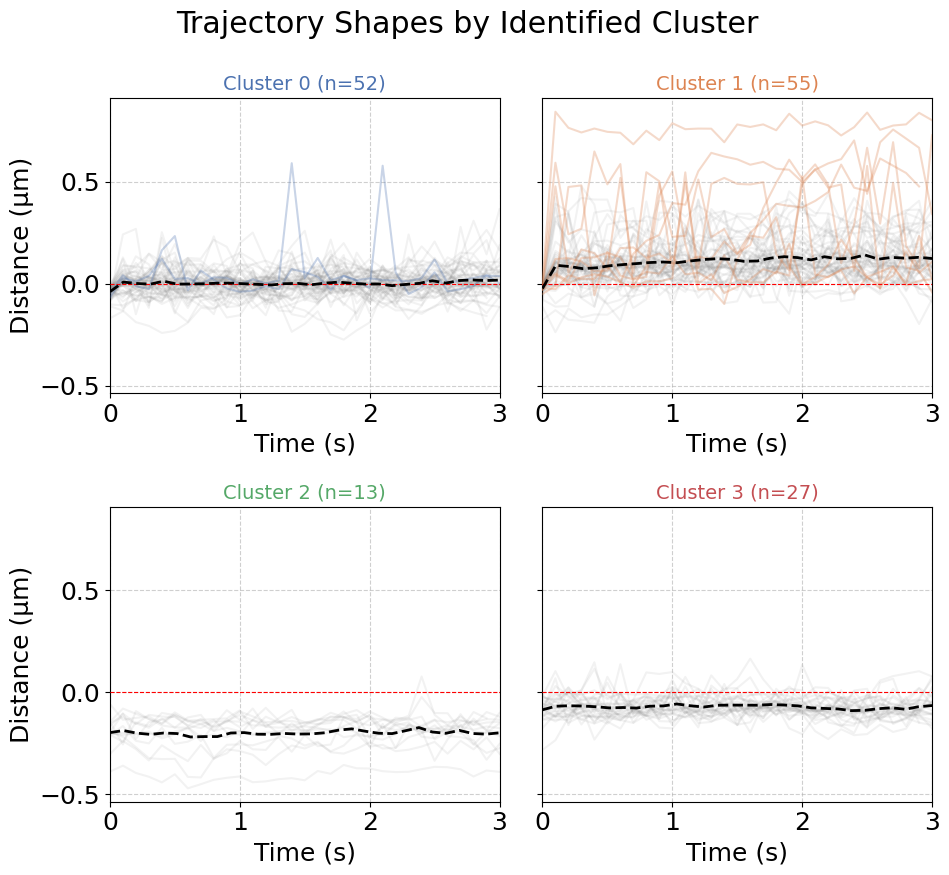

In [117]:

# --- Plot 2: The Original Trajectories Grouped by Cluster ---
import math

# --- 1. Setup the Grid Layout ---

# Get the unique cluster labels that we need to plot
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels)
n_cols = 2 # Number of plots you want in each row
n_rows = math.ceil(n_clusters / n_cols) # Calculate rows needed
# Create a figure that is large enough to hold the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows), sharey=True)

# Flatten the 2D array of axes into a 1D array for easy looping
# This also handles the case where n_rows is 1
axes = axes.flatten()

# --- 3. Loop Through Clusters and Plot Trajectories ---

for i, label in enumerate(unique_labels):
    ax = axes[i] # Select the subplot for the current cluster
    
    # Find all trajectories that belong to this cluster
    indices = np.where(cluster_labels == label)[0]
    
    distance_list = []
    # Plot each trajectory in this cluster
    for trace_idx in indices:
        trace_df = filtered_traces[trace_idx]
        
        if trace_df['distance_um'].max() > 0.5:
            ax.plot(trace_df['t'], trace_df['distance_um'], color=color_map[label], alpha=0.3, zorder=11)
            # pass
        else:
            ax.plot(trace_df['t'], trace_df['distance_um'], color='grey', alpha=0.1, zorder=1)
            distance_list.append(np.interp(common_time, trace_df['t'], trace_df['distance_um']))

    # Plot the average trajectory for this cluster
    if distance_list:
        distance_list = np.array(distance_list)
        # Calculate the average trajectory
        mean_distance = np.mean(distance_list, axis=0)
        # Plot the mean trajectory with a thicker line
        ax.plot(common_time, mean_distance, color='black', linewidth=2, label='Mean Trajectory', zorder=20, linestyle='--')
    
    # --- 4. Formatting for each Subplot ---
    ax.set_xlim(0, t_max)
    ax.axhline(0, color='red', linewidth=0.8, linestyle='--', zorder=12)
    
    # Set the title, handling the noise case
    title = f'Cluster {label} (n={len(indices)})' if label != -1 else f'Noise (n={len(indices)})'
    ax.set_title(title, color=color_map[label] if label != -1 else 'black', fontsize=14)
    
    ax.set_xlabel('Time (s)')
    ax.grid(True, linestyle='--', alpha=0.6)

# Add a y-axis label only to the first plot in each row for clarity
for i in range(n_rows):
    axes[i * n_cols].set_ylabel('Distance (μm)')

# --- 5. Clean Up and Display ---
plt.suptitle('Trajectory Shapes by Identified Cluster')
plt.tight_layout() # Adjust layout to make room for suptitle

# Remove any unused subplots
# for j in range(i + 2, len(axes)):
#     fig.delaxes(axes[j])

plt.savefig(f'result/cluster_img/n_neighbors={n_neighbors}, t_max={t_max}, n_clusters={N_CLUSTERS_TO_FIND}.png', dpi=300)
plt.show()

Performing UMAP on Cluster 1 with 55 traces.


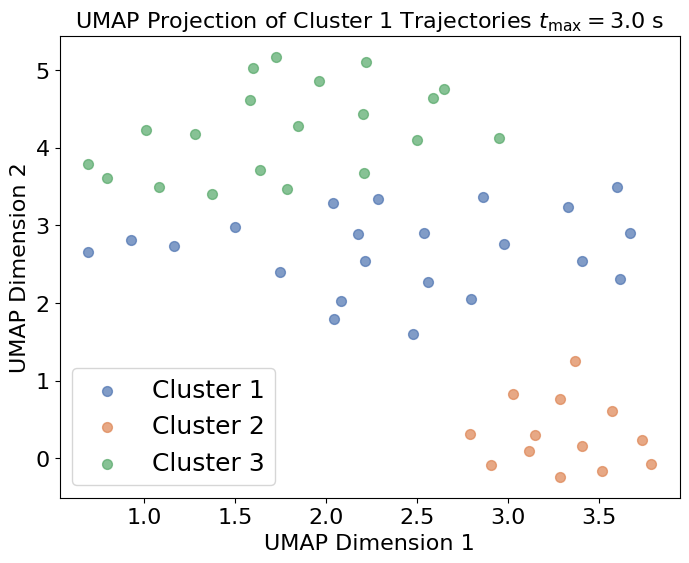

In [113]:
# Do KMeans clustering for Cluster 1 only
cluster_to_analyze = 1
indices = np.where(cluster_labels == cluster_to_analyze)[0]
if len(indices) > 0:
    cluster_data = data_matrix[indices]
    print(f"Performing UMAP on Cluster {cluster_to_analyze} with {len(indices)} traces.")
     
    # Perform UMAP
    n_neighbors = 15
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(cluster_data)

    # Perform KMeans clustering on the UMAP embedding
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(embedding)
    kmeans_labels = kmeans.labels_

    # Plot the UMAP result for this cluster
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for label in np.unique(kmeans_labels):
        idx = np.where(kmeans_labels == label)[0]
        ax.scatter(embedding[idx, 0], embedding[idx, 1], s=50, alpha=0.7, label=f'Cluster {label+1}', color=color_map[label % len(color_map)])

    plt.title(fr'UMAP Projection of Cluster {cluster_to_analyze} Trajectories $t_{{\text{{max}}}}={t_max}$ s', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=16)
    ax.set_ylabel('UMAP Dimension 2', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend()
    
    # plt.savefig(f'result/cluster_img/UMAP_Cluster{cluster_to_analyze}_n_neighbors={n_neighbors}.png', dpi=300)
    plt.show()

Plotting KMeans Cluster 0
Plotting KMeans Cluster 1
Plotting KMeans Cluster 2


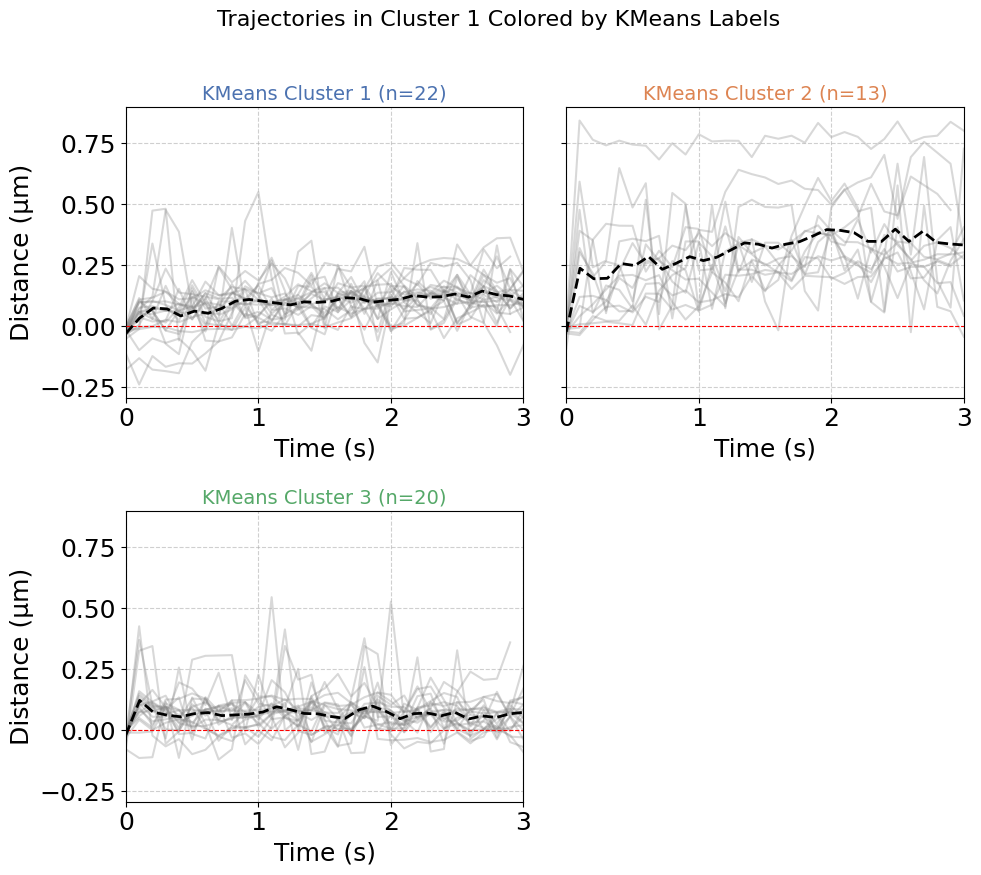

In [ ]:
# Plot the trajectories in this cluster colored by the new KMeans labels
n_cols = 2
n_rows = math.ceil(3 / n_cols) # Assuming 3 new clusters from KMeans
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows), sharey=True)
axes = axes.flatten()

# Create a color palette
unique_kmeans_labels = np.unique(kmeans_labels)
colors = sns.color_palette("deep", len(unique_kmeans_labels))
kmeans_color_map = {label: color for label, color in zip(unique_kmeans_labels, colors)}

# Get the original indices from the parent cluster
parent_cluster_indices = np.where(cluster_labels == cluster_to_analyze)[0]

for i, kmeans_label in enumerate(unique_kmeans_labels):
    print(f"Plotting KMeans Cluster {kmeans_label}")
    ax = axes[i] # Select the subplot for the current cluster
    
    # Find all trajectories that belong to this kmeans cluster
    kmeans_indices = np.where(kmeans_labels == kmeans_label)[0]
    distance_list = []
    
    # Plot each trajectory in this cluster
    for kmeans_idx in kmeans_indices:
        # Map back to the original filtered_traces index
        original_idx = parent_cluster_indices[kmeans_idx]
        trace_df = filtered_traces[original_idx]
        
        # Plot the trajectory
        ax.plot(trace_df['t'], trace_df['distance_um'], color='grey', alpha=0.3, zorder=0)
        distance_list.append(np.interp(common_time, trace_df['t'], trace_df['distance_um']))
        
    if distance_list:
        distance_list = np.array(distance_list)
        # Calculate the average trajectory
        mean_distance = np.mean(distance_list, axis=0)
        # Plot the mean trajectory with a thicker line
        ax.plot(common_time, mean_distance, color='black', linewidth=2, 
                label='Mean Trajectory', zorder=20, linestyle='--')
        
    ax.set_xlim(0, t_max)
    ax.axhline(0, color='red', linewidth=0.8, linestyle='--', zorder=12)
    ax.set_title(f'KMeans Cluster {kmeans_label+1} (n={len(kmeans_indices)})', 
                 color=kmeans_color_map[kmeans_label], fontsize=14)
    ax.set_xlabel('Time (s)')
    ax.grid(True, linestyle='--', alpha=0.6)

# Add y-axis labels
for i in range(n_rows):
    if i * n_cols < len(axes):
        axes[i * n_cols].set_ylabel('Distance (μm)')

# Remove unused subplots
for j in range(len(unique_kmeans_labels), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(fr'Trajectories in Cluster {cluster_to_analyze} Colored by KMeans Labels')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [111]:
# from sklearn.cluster import KMeans
# # --- Set the number of clusters you want to find ---
# n_clusters_to_find = 7

# # --- Instantiate and run KMeans ---
# # The 'n_init="auto"' argument is a modern default that helps get better results.
# kmeans = KMeans(n_clusters=n_clusters_to_find, random_state=42, n_init='auto')
# cluster_labels = kmeans.fit_predict(embedding)

# # 'cluster_labels' is now an array with values (0, 1) corresponding to your two clusters.
# # You can now proceed directly to your plotting code.

# # --- Example of the UMAP plotting section ---
# fig, ax = plt.subplots(figsize=(8, 6))

# for label in np.unique(cluster_labels):
#     try:
#         indices = np.where(cluster_labels == label)[0]
#         scatter = ax.scatter(
#             embedding[indices, 0],
#             embedding[indices, 1],
#             c=color_map[label],
#             s=50,
#             label=f'Cluster {label}'
#         )
#     except Exception as e:
#         print(f"Error plotting cluster {label}: {e}")

# plt.title(f'UMAP Projection with KMeans (k={n_clusters_to_find})', fontsize=16)
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')

# # Create a legend to identify clusters
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)

# plt.show()

In [112]:
# # =============================================================================
# # This code assumes you have the following variables from your analysis:
# #
# # cluster_labels: A NumPy array from KMeans with cluster IDs (e.g., 0, 1).
# #
# # original_traces: A list of your original trajectory DataFrames.
# # =============================================================================

# # --- 1. Setup the Grid Layout ---

# # Get the unique cluster labels (e.g., [0, 1])
# unique_labels = np.unique(cluster_labels)
# n_clusters = len(unique_labels)

# # Define a layout. For 2 clusters, 2 columns is perfect.
# n_cols = n_clusters 
# n_rows = 1

# # --- 2. Create the Figure and Color Palette ---

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), sharey=True)

# # Ensure 'axes' is an array even if there's only one plot
# if n_clusters == 1:
#     axes = [axes]

# # --- 3. Loop Through Clusters and Plot Trajectories ---

# for i, label in enumerate(unique_labels):
#     ax = axes[i]
    
#     # Find the indices of all trajectories belonging to the current cluster
#     indices = np.where(cluster_labels == label)[0]
    
#     for trace_idx in indices:
#         trace_df = filtered_traces[trace_idx]
#         ax.plot(trace_df['t'], trace_df['distance_um'], color=color_map[label], alpha=0.2)
#     # --- 4. Formatting for each Subplot ---
    
#     ax.set_title(f'Cluster {label} (n={len(indices)})', fontsize=14)
#     ax.set_xlabel('Time (s)')
#     ax.grid(True, linestyle='--', alpha=0.6)

# # Add a y-axis label to the first plot
# axes[0].set_ylabel('Distance to Boundary (μm)')

# plt.suptitle('Trajectory Shapes by KMeans Cluster', fontsize=18, y=1.02)
# plt.tight_layout()
# plt.show()